In [34]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import wandb
import argparse
import os

from pathlib import Path
BASE_PATH = str(Path(os.getcwd()).parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
print("BASE_PATH:", BASE_PATH)

import sys
sys.path.append(BASE_PATH)

# from _01_code._03_real_world_data_to_tensors.m_california_housing_dataset_dataloader \
#   import CaliforniaHousingDataset
from _03_homeworks.homework_2.titanic_dataset import get_preprocessed_dataset

BASE_PATH: c:\Users\as990\link_dl


In [35]:
def get_data():
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
  # print(titanic_dataset)
  # print(test_dataset)

  # train_dataset, validation_dataset = random_split(titanic_dataset, [0.8, 0.2])
  print(len(train_dataset), len(validation_dataset))

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  return train_data_loader, validation_data_loader, test_data_loader


class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      nn.LeakyReLU(),
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      nn.LeakyReLU(),
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x


def get_model_and_optimizer():
  my_model = MyModel(n_input=10, n_output=1)
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

  return my_model, optimizer


def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.MSELoss()  # Use a built-in loss function
  next_print_epoch = 100

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      input = train_batch['input'].float()
      target = train_batch['target'].float()
      output_train = model(input)
      loss = loss_fn(output_train, target)
      loss_train += loss.item()
      num_trains += 1

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        input = validation_batch['input'].float()
        target = validation_batch['target'].float()
        output_validation = model(input)
        loss = loss_fn(output_validation, target)
        loss_validation += loss.item()
        num_validations += 1

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations
    })

    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
      next_print_epoch += 100

import pandas as pd

def inference(model, test_data_loader):
    predictions = []
    with torch.no_grad():
        customerID = 892
        for test_batch in test_data_loader:
            input = test_batch['input'].float()
            output_test = model(input)
            binary_pred = (output_test > 0.5).float()
            
            # Convert to list and pair with customer IDs
            for pred in binary_pred:
                predictions.append([customerID, int(pred.item())])
                customerID += 1
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(predictions, columns=['CustomerID', 'Prediction'])
    df.to_csv('predictions.csv', index=False)
    print(f"Saved {len(predictions)} predictions to predictions.csv")
    
    return predictions


def main(args):
  current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': 1e-3,
    'n_hidden_unit_list': [20, 20],
  }

  wandb.init(
    mode="online",
    project="my_model_training",
    notes="My first wandb experiment",
    tags=["my_model", "titanic dataset"],
    name=current_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, test_data_loader = get_data()
  print(test_data_loader)

  linear_model, optimizer = get_model_and_optimizer()

  print("#" * 50, 1)

  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )

  inference(model=linear_model, test_data_loader=test_data_loader)

  wandb.finish()

In [36]:
# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=64, help="Batch size (int, default: 512)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=2_000, help="Number of training epochs (int, default:1_000)"
  )

  # Fix: Use parse_known_args() instead of parse_args()
  args, unknown = parser.parse_known_args()

  main(args)

Namespace(wandb=False, batch_size=64, epochs=2000)
{'epochs': 2000, 'batch_size': 64, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}


c:\Users\as990\link_dl\_03_homeworks\homework_2\titanic_dataset.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
c:\Users\as990\link_dl\_03_homeworks\homework_2\titanic_dataset.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.

c:\Users\as990\anaconda3\envs\link_dl\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\as990\anaconda3\envs\link_dl\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\as990\anaconda3\envs\link_dl\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([178])) that is different to the input size (torch.Size([178, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

Epoch 100, Training loss 0.2506, Validation loss 0.2544
Epoch 200, Training loss 0.2361, Validation loss 0.2344
Epoch 300, Training loss 0.2423, Validation loss 0.2346
Epoch 400, Training loss 0.2413, Validation loss 0.2330
Epoch 500, Training loss 0.2400, Validation loss 0.2349
Epoch 600, Training loss 0.2396, Validation loss 0.2352
Epoch 700, Training loss 0.2360, Validation loss 0.2332
Epoch 800, Training loss 0.2366, Validation loss 0.2327
Epoch 900, Training loss 0.2392, Validation loss 0.2326
Epoch 1000, Training loss 0.2401, Validation loss 0.2337
Epoch 1100, Training loss 0.2403, Validation loss 0.2350
Epoch 1200, Training loss 0.2352, Validation loss 0.2333
Epoch 1300, Training loss 0.2379, Validation loss 0.2325
Epoch 1400, Training loss 0.2390, Validation loss 0.2329
Epoch 1500, Training loss 0.2369, Validation loss 0.2325
Epoch 1600, Training loss 0.2373, Validation loss 0.2323
Epoch 1700, Training loss 0.2397, Validation loss 0.2327
Epoch 1800, Training loss 0.2392, Valida

Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▆▃▄▃▅▆▇▂▃▅▆▃▆▃▆▄▁▃▄▃▃▂▃▂▃▃▂▃▅▂▅▃▃▅▁▂▃▂▄
Validation loss,█▄▃▃▂▃▂▃▂▄▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▄▁▃▃▁▁▁▁▁▁▂▁▂▁▁
Epoch,2000
Training loss,0.23906
Validation loss,0.23285


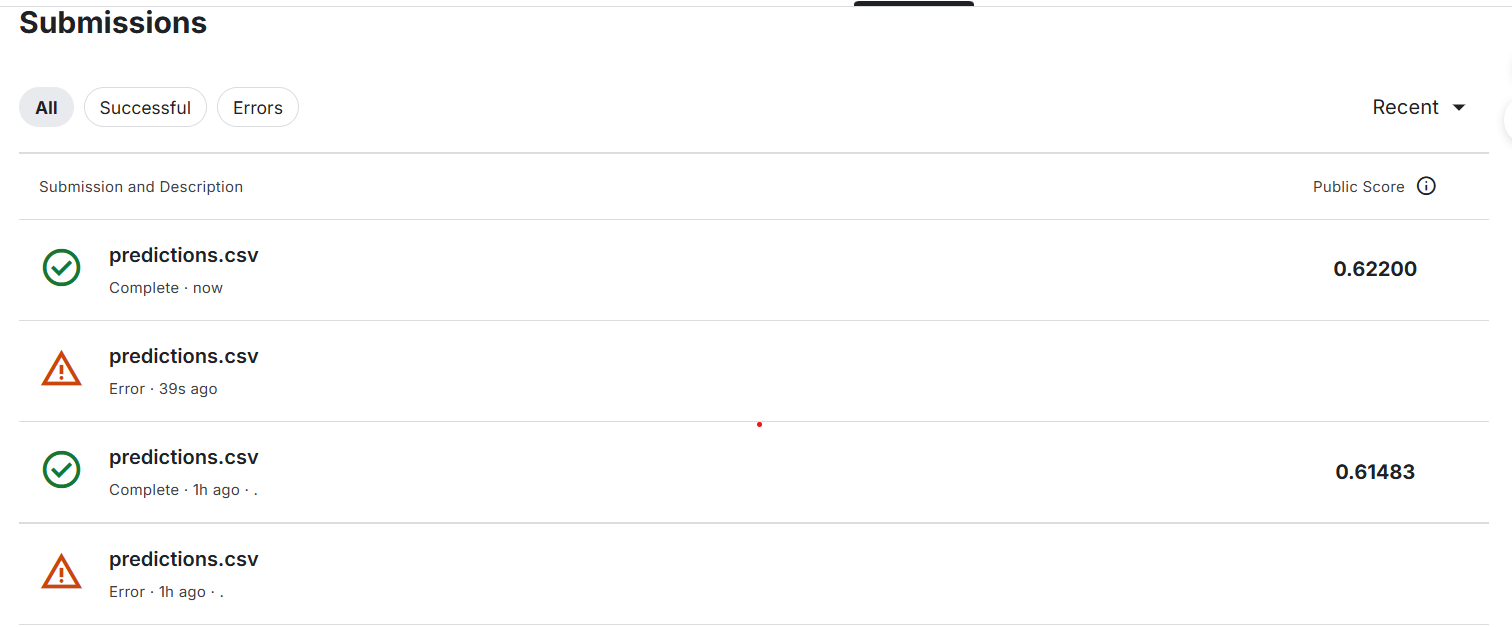
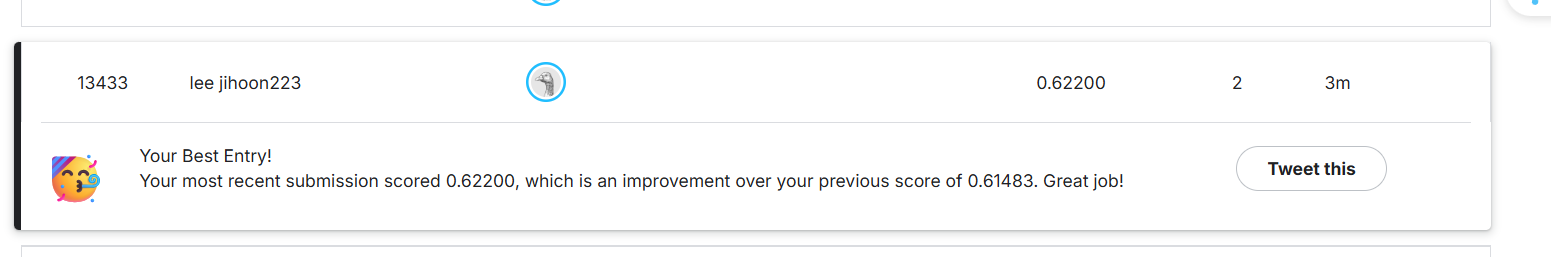

### 숙제 후기
전반적인 딥러닝 과정을 파악하고 훈련시킬수 있는 경험이었습니다.